In [1]:
print spark, sc

<pyspark.sql.session.SparkSession object at 0x7f0c21597c90> <pyspark.context.SparkContext object at 0x7f0c21675f10>


In [2]:
tweetJsonDF = spark.read.json('s3n://spark-bucket-ishwar/Donald_Trump.json')
# tweetJsonDF.printSchema()

In [3]:
from pyspark.sql.functions import size
tweetJsonDF = tweetJsonDF.filter(size(tweetJsonDF['entities.hashtags.text']) > 0)
tweetJsonDF = tweetJsonDF.select('user.screen_name', 'user.followers_count','user.verified',
                   'text', tweetJsonDF['entities.hashtags.text'].alias('hashtags'),
                   'retweet_count', 'favorite_count', 'possibly_sensitive',
                   'lang').orderBy('retweet_count', ascending = False)

tweetJsonDF.show()
# from pyspark.sql import Row
# from pyspark.sql.functions import explode
# eDF = spark.createDataFrame([Row(a=1, intlist=[1,2,3], mapfield={"a": "b"})])
# eDF.show()
# eDF.select(explode('mapfield')).show()

+---------------+---------------+--------+--------------------+--------------+-------------+--------------+------------------+----+
|    screen_name|followers_count|verified|                text|      hashtags|retweet_count|favorite_count|possibly_sensitive|lang|
+---------------+---------------+--------+--------------------+--------------+-------------+--------------+------------------+----+
|_DONALD__trump_|            213|   false|RT @MrLukeJohnsto...|[PlanetEarth2]|       201173|             0|             false|  en|
|    queenvexuss|             46|   false|RT @HillaryClinto...| [debatenight]|       100852|             0|             false|  en|
|NatalieJPierson|           1403|   false|RT @HillaryClinto...| [debatenight]|       100850|             0|             false|  en|
| olyapiputatova|              7|   false|RT @HillaryClinto...|    [VPDebate]|        30181|             0|              null|  en|
|        Gas8128|          18290|   false|RT @realDonaldTru...|[AmericaFirst

In [6]:
from operator import add
from pyspark.sql import types

list_of_lists = [['a','b','c'],['d','e'],['a','b','e','f'],['b']]

# Create an RDD from a list of lists
rddx = sc.parallelize(list_of_lists)
rdd1 = rddx.flatMap(lambda x: x ).map(lambda x: (x,1)).reduceByKey(add) \
           .map(lambda x: (x[1],x[0])).sortByKey(ascending = False).map(lambda x: (x[1],x[0]))
print rdd1.take(10)
df1 = spark.createDataFrame(rdd1, ['alphabet', 'count'])
rdd2 = df1.select('alphabet').rdd
print rddx.collect()

# Convert a list of lists into a Spark DataFrame
dfx = spark.createDataFrame(list_of_lists, schema=types.ArrayType(types.StringType()))
dfx = dfx.select(dfx['value'].alias('alphabet_list'))
dfx.show()
rddy = dfx.rdd.map(lambda row:row['alphabet_list'])
print rddy.collect()
rdd3 = rddy.flatMap(lambda x: x ).map(lambda x: (x,1)).reduceByKey(add) \
           .map(lambda x: (x[1],x[0])).sortByKey(ascending = False).map(lambda x: (x[1],x[0]))
print rdd3.take(10)
df2 = spark.createDataFrame(rdd3, ['alphabet', 'count'])
df2.show()



In [5]:
from operator import add
from pyspark.sql import types
# Select just the hashtags column
hashtagDF = tweetJsonDF.select('hashtags')
hashtagRDD = hashtagDF.rdd.map(lambda row:row['hashtags'])
# print hashtagRDD.collect()
hashtagRDD_1 = hashtagRDD.flatMap(lambda x: x ).map(lambda x: (x,1)).reduceByKey(add) \
           .map(lambda x: (x[1],x[0])).sortByKey(ascending = False).map(lambda x: (x[1],x[0]))
print hashtagRDD_1.take(10)
hashtagDF_1 = spark.createDataFrame(hashtagRDD_1, ['hashtag', 'count'])
hashtagDF_1.show()


[(u'Trump2016', 23462), (u'TrumpTrain', 22468), (u'Trump', 11259), (u'MAGA', 10712), (u'SNL', 5951), (u'SoundCloud', 5548), (u'TrumpLeaks', 3733), (u'DonaldTrump', 3577), (u'ThankYouTour2016', 2803), (u'msnbc', 2611)]
+----------------+-----+
|         hashtag|count|
+----------------+-----+
|       Trump2016|23462|
|      TrumpTrain|22468|
|           Trump|11259|
|            MAGA|10712|
|             SNL| 5951|
|      SoundCloud| 5548|
|      TrumpLeaks| 3733|
|     DonaldTrump| 3577|
|ThankYouTour2016| 2803|
|           msnbc| 2611|
|             cnn| 2486|
|ElectoralCollege| 2473|
|          PEOTUS| 2365|
|    AmericaFirst| 2115|
|           amjoy| 2031|
|            DAPL| 1780|
|      BroseRoyce| 1708|
|           AMJoy| 1630|
|  NotMyPresident| 1581|
|   NorthCarolina| 1503|
+----------------+-----+
only showing top 20 rows



In [6]:
# Limit hashtag Dataframe to top 10 rows
from pyspark.sql import functions as F
hashtagDF_wc = hashtagDF_1.limit(300)
hashtagDF_1 = hashtagDF_1.limit(10)
hashtagDF_1.show()

# row = hashtagDF_1.agg(F.max(hashtagDF_1['count']).alias('maxcount')).collect()
# y_max = row[0]['maxcount']

hashtag_pandaDF = hashtagDF_1.toPandas()
hashtag_pandaDF['hashtag'] = '#' + hashtag_pandaDF['hashtag'].astype(str)
y_max = hashtag_pandaDF.iloc[0][1]
print "y_max:", y_max

+----------------+-----+
|         hashtag|count|
+----------------+-----+
|       Trump2016|23462|
|      TrumpTrain|22468|
|           Trump|11259|
|            MAGA|10712|
|             SNL| 5951|
|      SoundCloud| 5548|
|      TrumpLeaks| 3733|
|     DonaldTrump| 3577|
|ThankYouTour2016| 2803|
|           msnbc| 2611|
+----------------+-----+

y_max: 23462


In [7]:
%matplotlib inline
import numpy as np
import seaborn as sns


In [8]:
hashtag_pandaDF

,hashtag,count
0,#Trump2016,23462
1,#TrumpTrain,22468
2,#Trump,11259
3,#MAGA,10712
4,#SNL,5951
5,#SoundCloud,5548
6,#TrumpLeaks,3733
7,#DonaldTrump,3577
8,#ThankYouTour2016,2803
9,#msnbc,2611


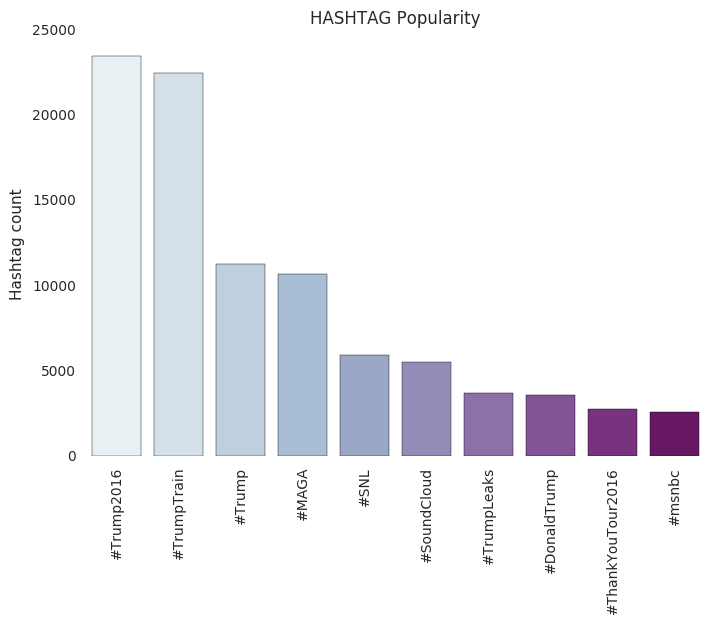

In [9]:
# hashtagDF_1.show()
sns.set(style="white")

g = sns.barplot(x='hashtag',y='count',data=hashtag_pandaDF, palette="BuPu")
g.set_ylabel('Hashtag count')
g.set_xlabel('')
g.set_xticklabels(g.get_xticklabels(),rotation=90)
sns.despine(left=True,bottom=True)
sns.plt.title('HASHTAG Popularity')

In [10]:
import os
os.listdir('.')

['spark-class2.cmd',
 'beeline.cmd',
 'spark-sql',
 'pyspark2.cmd',
 'run-example',
 'derby.log',
 'spark-submit',
 'Untitled.ipynb',
 'cloud-project.ipynb',
 'spark-submit2.cmd',
 'spark-shell.cmd',
 'spark-class.cmd',
 'pyspark.cmd',
 'beeline',
 'load-spark-env.cmd',
 'spark-shell',
 'run-example.cmd',
 'metastore_db',
 'sparkR2.cmd',
 'pyspark',
 'sparkR.cmd',
 'load-spark-env.sh',
 'spark-shell2.cmd',
 'test_notebook.ipynb',
 'spark-class',
 '.ipynb_checkpoints',
 'sparkR',
 'spark-submit.cmd']

In [13]:
# Generating a square wordcloud from the hashtags

from os import path
from wordcloud import WordCloud

<img src="https://raw.githubusercontent.com/amueller/word_cloud/master/examples/constitution.png">